# Run this notebook to produce affinities for JLab 12, JLab22, HERMES, COMPASS, and EIC. The choice of experiments to be done in the last cell

In [47]:
from __future__ import division
import numpy as np
import ratlib as rat
import pandas as pd
import params as par
from tools import save, load, lprint, checkdir
import matplotlib.pyplot as plot
import time

## This function calculates affinities according to the table: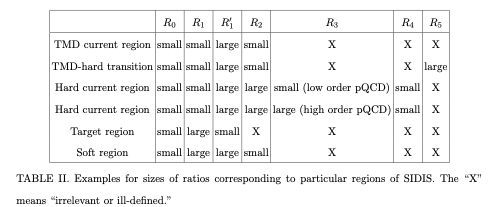

In [49]:
def get_affinity(params,R0max,R1max,R2max,R3max,R4max,R5max,R1pmax,R1min,R2min,R3min,R1pmin):
    
    M         = params['M'] 
    M_h       = params['M_h']
    x         = params['x_bj']
    z         = params['z_h']
    Q         = params['Q']
    qT        = params['q_t']
    xi        = params['xi']
    zeta      = params['zeta']
    dkT       = params['delta_k_t']
    kit       = params['k_i_t']
    ki        = params['M_ki']
    kf        = params['M_kf']
    phi_i     = params['phi_i']
    phi       = params['phi']
    phi_ki       = params['phi_ki']

    R0_12 = np.maximum(
            np.abs(rat.get_R01( M,M_h,x,z,Q,qT,xi,zeta,dkT,kit,ki,kf,phi_i,phi,phi_ki)),
            np.abs(rat.get_R02( M,M_h,x,z,Q,qT,xi,zeta,dkT,kit,ki,kf,phi_i,phi,phi_ki))
            )
    R0 = np.maximum(R0_12,
            np.abs(rat.get_R03( M,M_h,x,z,Q,qT,xi,zeta,dkT,kit,ki,kf,phi_i,phi,phi_ki))
            )

    R1 = np.abs(rat.get_R1( M,M_h,x,z,Q,qT,xi,zeta,dkT,kit,ki,kf,phi_i,phi,phi_ki))
    R2 = np.abs(rat.get_R2( M,M_h,x,z,Q,qT,xi,zeta,dkT,kit,ki,kf,phi_i,phi,phi_ki))
    
#     # Rowan: Calculate R2 according to MC assumptions / vector product
#     # This (R2_calc) matches what I get from MC bc we assume k = kf - q = ki
#     R2_calc = ki**2 / (Q**2)
#     d = {'R2': R2, 'R2_calc': R2_calc}
#     data = pd.DataFrame(data=d)
#     data.to_csv('data/R2_values')
#     plot.title("R2 and R2_calc plotted on top of each other")
# #     edges = np.linspace(0, 10, 100)
#     plot.hist(R2_calc,bins=100,alpha = 0.4,label = "R2 by hand");
#     plot.hist(R0,bins=100,alpha = 0.4,label = "R2 from ratlib",color = "red");
#     plot.legend();
    
#     #Rowan: I also plot them on top of each other to show that both are present
#     fig,axs = plot.subplots(2,1, figsize = (5,8))
# #     fig.suptitle("R2 and R2 calc plotted one by one")
#     axs[0].hist(R2_calc,bins = 100,alpha = 0.4,label = "R2 by hand");
#     axs[1].hist(R2,bins = 100,alpha = 0.4,label = "R2 from ratlib",color = "red");
# #     axs[1].set_xticks(np.arange(0, 4.1, step=0.5))
# #     axs[0].set_xticks(np.arange(0, 4.1, step=0.5))
#     axs[0].legend()
#     axs[1].legend()
    
#     # Rowan: Now print out the percent of R2 values that correspond to TMD affinity (R2 < 0.3)
#     num_points_lessthan_03_calc = len(R2_calc[R2_calc < 0.3])
#     num_points_lessthan_03_driver = len(R2[R2 < 0.3])
#     num_points_lessthan_03_driver1 = len(R0[R0 < 0.3])
#     print(f"\n\nThe percent of events where R2_calc < 0.3 is: {num_points_lessthan_03_calc / len(R2_calc) *100}%")
#     print(f"The percent of events where R2 (driver) < 0.3 is: {num_points_lessthan_03_driver / len(R2) *100}%")
#     print(f"The percent of events where R0 (driver) < 0.3 is: {num_points_lessthan_03_driver1 / len(R0) *100}%")
    
# #     Rowan: I just want to look at the values for one instance for testing,
# #     so I stop the program here and look at the plots/printed numbers
#     return
    
    
    R3 = np.abs(rat.get_R3( M,M_h,x,z,Q,qT,xi,zeta,dkT,kit,ki,kf,phi_i,phi,phi_ki))
    
    R_values = pd.DataFrame({'R0': R0, 'R1': R1, 'R2': R2, 'R3': R3})
    
    R_values.to_csv('data/R_values_Rowan.csv')
   
    R4 = np.maximum(
            np.abs(rat.get_R41( M,M_h,x,z,Q,qT,xi,zeta,dkT,kit,ki,kf,phi_i,phi,phi_ki)),
            np.abs(rat.get_R42( M,M_h,x,z,Q,qT,xi,zeta,dkT,kit,ki,kf,phi_i,phi,phi_ki)),
            np.abs(rat.get_R43( M,M_h,x,z,Q,qT,xi,zeta,dkT,kit,ki,kf,phi_i,phi,phi_ki))
            )   

    R1p = np.abs(rat.get_R1p( M,M_h,x,z,Q,qT,xi,zeta,dkT,kit,ki,kf,phi_i,phi,phi_ki))
    
    
    R5 = np.abs(np.log(R2))

    
    size=len(R1)
    
    
    partonic_affinity = 0

    current_affinity = 0

    tmd_affinity = 0
    tmd_np_affinity = 0

    collinear_affinity = 0
    collinear_loworder_affinity = 0
    collinear_highorder_affinity = 0
    matching_affinity = 0
    target_affinity = 0
    soft_affinity = 0
    unclassified_affinity = 0 
    
   
    for i in range(size):
        # For partonic interpretation we have R0 << 1
        partonic = R0[i]<R0max
        if partonic : partonic_affinity += 1./size

        # For current region interpretation we have R1 << 1
        current = R1[i]<R1max
        if current : current_affinity += 1./size
            
        # for TMD affinity we have partonic, current region, and R2 << 1 NOTICE we do not use R1p as it does not appear to be reliable for current region
        tmd = R2[i]<R2max 
        tmdregion = partonic and current and tmd
        if tmdregion : tmd_affinity += 1./size
            
        # for non perturbative tmd R5 is small (resummation is not very important)    
        tmdnp = tmd and R5[i]<R5max 
        if partonic and current and tmdnp : tmd_np_affinity += 1./size
   
        #collinear QCD = partonic, current region, and R2 >> 1 and R4 << 1
        collinear = R2[i]>R2min and R4[i]<R4max
        collinearregion = partonic and current and collinear
        if collinearregion : collinear_affinity += 1./size

        #collinear QCD low order = collinear and R3 << 1 (2->2 process)
        collinearLowOrder = collinear and R3[i]<R3max 
        if partonic and current and collinearLowOrder : collinear_loworder_affinity += 1./size

        #collinear QCD high order = collinear and R3 >> 1 (2->3 process)
        collinearHighOrder = collinear and R3[i]>R3min 
        if partonic and current and collinearHighOrder : collinear_highorder_affinity += 1./size

        #for target region affinity we have partonic, not current region, and R1p << 1
        notcurrent = R1[i]>R1min
        target = R1p < R1pmax
        targetregion = partonic and notcurrent and target
        if targetregion : target_affinity += 1./size

        # The central (or soft) region is characterized by the production of  hadrons that are not the products of hard scattering but do not associate in any obvious way to a quark or target direction either.
        softregion = partonic and not current and not target and not collinear
        if softregion : soft_affinity += 1./size
                       
        # Matching is the region in between of TMD (R2<<1) and Collinear (R2>>1) regions
        matching = R2[i] > R2max and R2[i] < R2min
        if partonic and current and matching : matching_affinity += 1./size

        unclassifiedregion = not tmdregion and not collinearregion and not softregion and not targetregion
        if unclassifiedregion : unclassified_affinity += 1./size            
        
    # yi and yf depend on partonic kinematics    
    yi = rat.get_yi(M,M_h,x,z,Q,qT,xi,zeta,dkT,kit,ki,kf,phi_i,phi,phi_ki)
    yf = rat.get_yf(M,M_h,x,z,Q,qT,xi,zeta,dkT,kit,ki,kf,phi_i,phi,phi_ki)
            
    return partonic_affinity,current_affinity,tmd_affinity,tmd_np_affinity,collinear_affinity,collinear_loworder_affinity,collinear_highorder_affinity,matching_affinity,soft_affinity,target_affinity,unclassified_affinity,R0,R1,R2,R3,R4,R1p,yi,yf


## This functions processes kinematics for experiments

In [50]:
def process_kinematics(fname,R0max,R1max,R2max,R3max,R4max,R5max,R1pmax,R1min,R2min,R3min,R1pmin,size):
    """
    Compute affinity accross kinematics of fname file 
    """
    print("We open file ",fname) # Write what file we open from directory /expdata
    tab = pd.read_excel(fname)
    tab=tab.to_dict(orient='list')
    npts=len(tab[list(tab.keys())[0]])


    tab['partonicaff']=[]
    tab['currentaff']=[]


    tab['tmdaff']=[]
    tab['tmdnpaff']=[]

    tab['collinearaff']=[]
    tab['collinearloworderaff']=[]
    tab['collinearhighorderaff']=[]
    tab['matchaff']=[]
    tab['softaff']=[]
    tab['targetaff']=[]
    tab['unclassifiedaff']=[]

    tab['R0'] = []
    tab['R1'] = []
    tab['R1p'] = []
    tab['R2'] = []
    tab['R3'] = []
    tab['R4'] = []
    tab['R5'] = []
     
 
    # Let us modify the data file and add qT, xN, zN:   
    tab['qT'] = []
    tab['xN'] = []
    tab['zN'] = []
    tab['yp'] = []
    tab['yh'] = []
    tab['yhtarget'] = []
    tab['yi'] = []
    tab['yf'] = []




    
    for i in range(npts):
        tab['qT'].append(tab['pT'][i]/tab['z'][i]) # We will modify it later in this cell line 129
        tab['xN'].append(tab['x'][i]) # We will modify it later
        tab['zN'].append(tab['z'][i]) # We will modify it later
        tab['yp'].append(tab['x'][i]) # We will modify it later
        tab['yh'].append(tab['x'][i]) # We will modify it later
        tab['yhtarget'].append(tab['x'][i]) # We will modify it later (this is for target region)

    # Rapidities yi, yf depend on external partonic variables



    for i in range(npts):
        lprint('%d/%d'%(i,npts))        
        x   = tab['x'][i]
        z   = tab['z'][i]
        if 'pT' not in tab.keys(): 
            pT  = tab['pT2'][i]**0.5
        if 'pT' in tab.keys(): 
            pT  = tab['pT'][i]           
        Q2  = tab['Q2'][i]
        tar = tab['target'][i]
        had = tab['hadron'][i]

        params={}

        params['x_bj'] = x
        params['z_h']  = z
        

        
        #Our functions take pT/z as an argument TODO check it
        params['q_t']  = pT/z    
            
        params['Q']    = Q2**0.5

        if tar.startswith('p'):
            params['M']    = par.M  
        elif tar.startswith('n'):
            params['M']    = par.MN
        elif tar.startswith('d'):
            params['M']    = par.MD
            
        if had.startswith('pi'):  
            params['M_h']=par.Mpi  
            if had.endswith("+"):
                params['M_h']=par.Mpip
            elif had.endswith("-"):
                params['M_h']=par.Mpim
            elif had.endswith("0"):
                params['M_h']=par.Mpi0   
        if had.startswith('k'):  
            params['M_h']=par.Mk    
            if had.endswith("+"):
                params['M_h']=par.Mkp
            elif had.endswith("-"):
                params['M_h']=par.Mkm
            elif had.endswith("0"):
                params['M_h']=par.Mk0 
                
        if had.startswith('h'):  
            params['M_h']=par.Mpi
            if had.endswith("+"):
                params['M_h']=par.Mpip
            elif had.endswith("-"):
                params['M_h']=par.Mpim
            elif had.endswith("0"):
                params['M_h']=par.Mpi0

        # Let us modify the data file and add qT:
#        if 'qT' not in tab.keys():            
        M         = params['M'] 
        M_h       = params['M_h']
        x         = params['x_bj']
        z         = params['z_h']
        Q         = params['Q']
        qT        = params['q_t']
        xi        = x # Not important for qT
        zeta      = z # Not important for qT
        dkT       = 0
        kit       = 0
        ki        = 0
        kf        = 0
        phi_i     = 0
        phi       = 0
        phi_ki       = 0
        #xN,zN, and qT do not depend on partonic variables, let us add them here
        tab['qT'][i] = np.sqrt( rat.get_qT2( M,M_h,x,z,Q,qT,xi,zeta,dkT,ki,kit,kf,phi_i,phi,phi_ki) ) 
        tab['xN'][i] = rat.get_xN( M,M_h,x,z,Q,qT,xi,zeta,dkT,ki,kit,kf,phi_i,phi,phi_ki)  
        tab['zN'][i] = rat.get_zN( M,M_h,x,z,Q,qT,xi,zeta,dkT,ki,kit,kf,phi_i,phi,phi_ki)  
        tab['yp'][i] = rat.get_yp( M,M_h,x,z,Q,qT,xi,zeta,dkT,ki,kit,kf,phi_i,phi,phi_ki)  
        tab['yh'][i] = rat.get_yh( M,M_h,x,z,Q,qT,xi,zeta,dkT,ki,kit,kf,phi_i,phi,phi_ki)  
        tab['yhtarget'][i] = rat.get_yh_target( M,M_h,x,z,Q,qT,xi,zeta,dkT,ki,kit,kf,phi_i,phi,phi_ki)  





               
        
        #gen_np_values(params,x,z,0,size=size)  # test here
        gen_np_values(params,x,z,2,size=size) # Main level=2

        partonic_affinity,current_affinity,tmd_affinity,tmd_np_affinity,collinear_affinity,collinear_loworder_affinity,collinear_highorder_affinity,matching_affinity,soft_affinity,target_affinity,unclassified_affinity,R0,R1,R2,R3,R4,R1p,yi,yf = get_affinity(params,R0max,R1max,R2max,R3max,R4max,R5max,R1pmax,R1min,R2min,R3min,R1pmin)

        tab['yi'].append(np.mean(yi))
        tab['yf'].append(np.mean(yf))


        
        if i == 0:
            R0MAX = max(R0)
            R0MIN = min(R0)
            R1MAX = max(R1)
            R1MIN = min(R1)
            R2MAX = max(R2)
            R2MIN = min(R2)
            R3MAX = max(R3)
            R3MIN = min(R3)
            R4MAX = max(R4)
            R4MIN = min(R4)
            R1PMAX = R1p
            R1PMIN = R1p
        else:
            if max(R0)> R0MAX: R0MAX = max(R0)
            if min(R0)< R0MIN: R0MIN = min(R0)
            if max(R1)> R1MAX: R1MAX = max(R1)
            if min(R1)< R1MIN: R1MIN = min(R1)
            if max(R2)> R2MAX: R2MAX = max(R2)
            if min(R2)< R2MIN: R2MIN = min(R2)
            if max(R3)> R3MAX: R3MAX = max(R3)
            if min(R3)< R3MIN: R3MIN = min(R3)
            if max(R4)> R4MAX: R4MAX = max(R4)
            if min(R4)< R4MIN: R4MIN = min(R4)
            if R1p> R1PMAX: R1PMAX = R1p
            if R1p< R1PMIN: R1PMIN = R1p

 # Let us also save values for Rs here, we will save mean values of Rs obtained in Monte Carlo:
        tab['R0'].append(np.mean(R0))
        tab['R1'].append(np.mean(R1))
        tab['R1p'].append(np.mean(R1p))
        tab['R2'].append(np.mean(R2))
        tab['R3'].append(np.mean(R3))
        tab['R4'].append(np.mean(R4))
        tab['R5'].append(np.abs(np.log(np.mean(R4))))

        tab['partonicaff'].append(partonic_affinity)
        tab['currentaff'].append(current_affinity)     
        tab['tmdaff'].append(tmd_affinity)
        tab['tmdnpaff'].append(tmd_np_affinity)
        tab['collinearaff'].append(collinear_affinity)
        tab['collinearloworderaff'].append(collinear_loworder_affinity)
        tab['collinearhighorderaff'].append(collinear_highorder_affinity)
        tab['matchaff'].append(matching_affinity)
        tab['softaff'].append(soft_affinity)
        tab['targetaff'].append(target_affinity)
        tab['unclassifiedaff'].append(unclassified_affinity)
      
    print("\n R0max = %s, R0min = %s"%(R0MAX, R0MIN))
    print("\n R1max = %s, R1min = %s"%(R1MAX, R1MIN))
    print("\n R2max = %s, R2min = %s"%(R2MAX, R2MIN))
    print("\n R3max = %s, R3min = %s"%(R3MAX, R3MIN))
    print("\n R4max = %s, R4min = %s"%(R4MAX, R4MIN))
    print("\n R1pmax = %s, R1pmin = %s"%(R1PMAX, R1PMIN))


    tab=pd.DataFrame(tab)
    return tab

In [51]:
def write_affinity_to_excel(tab,output):
    print("We write otput into a file ",output) # Write what file we write output into directory /data
    tab.to_excel(output)      

In [53]:
def gen_np_values(params,x,z,level,size=100):    
    data = pd.read_csv('/Users/tetiana/Documents/Affinity/Affinity_CLAS12_values/CLAS12_all_values_1k.csv')
    
    delta = 0.1
    
    deltax = x+delta
    if deltax >= 1:
        deltax = 1
        
    deltaz = z+delta
    if deltaz >= 1:
        deltaz = 1

    
    params['xi']   = np.random.uniform(x,deltax,size) # Should we generate partonic variable in a wide interval?
    params['zeta'] = np.random.uniform(z,deltaz,size)



    if   level== 0: lower,upper=0.,0.225
    elif level== 1: lower,upper=0.0,0.25
    elif level== 2: lower,upper=0.0,par.M 
    #elif level== 2: lower,upper=0.25,0.75
    elif level== 3: lower,upper=0.01,0.05


#     params['delta_k_t'] =  np.abs(np.random.normal((upper+lower)/2,(upper-lower)/2,size))
#     params['k_i_t']     =  np.abs(np.random.normal((upper+lower)/2,(upper-lower)/2,size))
#     params['M_ki']      =  np.abs(np.random.normal((upper+lower)/2,(upper-lower)/2,size)) 
    params['M_kf']      =  np.abs(np.random.normal((upper+lower)/2,(upper-lower)/2,size))
    
    params['k_i_t'] = np.array(data['ki_t'])
    params['M_ki'] = np.array(data['M_ki'])
    params['delta_k_t'] = np.array(data['delta_k_t'])
    


    
    lower_phi = 0
    upper_phi = 2*np.pi
    params['phi']       = np.random.uniform(lower_phi,upper_phi,size)
    params['phi_i']     = np.random.uniform(lower_phi,upper_phi,size)
    params['phi_ki']     = np.random.uniform(lower_phi,upper_phi,size)
    
    Non_pert_par = pd.DataFrame({'xi': params['xi'], 'zeta': params['zeta'], 'delta_k_t': params['delta_k_t'],
                             'M_kf': params['M_kf'], 'k_iT': params['k_i_t'], 'M_ki': params['M_ki'], 
                                 'phi': params['phi'], 'phi_i': params['phi_i'], 'phi_ki': params['phi_ki']})
    
    Non_pert_par.to_csv('data/Gaus_MC_mixed.csv')

## Here specific choice of the "box" size and experiment is made

In [60]:
def main00(experiment):

    checkdir('data')

    # EXPERIMENTS TO BE CHOSEN
    if experiment == "JLAB":
        
        print('Processing JLab12')
        fnames = {'jlab12.xlsx'}
        
    elif experiment == "JLAB_MC":
        
        print('Processing JLab12_MC')
        #fnames = {'jlab22gridmy.xlsx'}
        fnames = {'CLAS12_1400.xlsx'}
        
    elif experiment == "SIM_B":
        print('Processing Similar bin')
        fnames = {'Rowan_similar_bin.xlsx'}
#         fnames = {'Harut_similar_bin.xlsx'}
        
    elif experiment == "JLAB22":
        
        print('Processing JLab22')
        #fnames = {'jlab22gridmy.xlsx'}
        fnames = {'jlab22_kap.xlsx'}
         
    elif experiment == "EIC": 
        
        print('Processing EIC')
        fnames = {'eic.xlsx'}
        
    elif experiment == "COMPASS": 
        
        print('Processing COMPASS')
        fnames={'1008.xlsx','1009.xlsx'} #{'compass17.xlsx'} # COMPASS to be verify
        
    elif experiment == "HERMES":  
        
        print('Processing HERMES')
        fnames = {'1010.xlsx','1011.xlsx','1012.xlsx','1013.xlsx','1014.xlsx','1015.xlsx','1016.xlsx','1017.xlsx'} # Hermes
        
    else:
        
        print("Usage: main00(experiment), experiment = 'JLAB', 'EIC', 'HERMES', 'COMPASS'")
        return 1

    # The "box" size ~ qT/Q < 0.3 
    R0max = 0.3

    R1max = 0.3
    R1min = R1max*3
    
    R2max = 0.3
    R2min = R2max*3
    
    R3max = 0.3
    R3min = R3max*3
    
    R4max = 0.3
    R5max = 0.3
 
    R1pmax= 0.3
    R1pmin= R1pmax*3

    
    #--compute affinity
    size=1000
    
    
    # if Rowan's data:
    # EXPERIMENT = JLAB_MC
#     for fname in fnames:
#         tab=process_kinematics('/Users/tetiana/Documents/Affinity/Clas12_and_Jlab12/'+fname,R0max,R1max,R2max,R3max,R4max,R5max,R1pmax,R1min,R2min,R3min,R1pmin,size)
#         output = 'data/'+fname.rsplit('.', 1)[0]+'affinity'+'_Rowan_data_'+str(R2max)+'.'+fname.rsplit('.', 1)[1]
#         write_affinity_to_excel(tab,output)
        
    # if Harut's data:
    # EXPERIMENT = JLAB
#     for fname in fnames:
#         tab=process_kinematics('/Users/tetiana/Documents/Affinity/expdata/'+fname,R0max,R1max,R2max,R3max,R4max,R5max,R1pmax,R1min,R2min,R3min,R1pmin,size)
#         output = 'data/'+fname.rsplit('.', 1)[0]+'affinity'+'_Harut_data_'+str(R2max)+'.'+fname.rsplit('.', 1)[1]
#         write_affinity_to_excel(tab,output)
        
    # if similar bin:
    # EXPERIMENT = SIM_B
    for fname in fnames:
        tab=process_kinematics('/Users/tetiana/Documents/Affinity/Clas12_and_Jlab12/'+fname,R0max,R1max,R2max,R3max,R4max,R5max,R1pmax,R1min,R2min,R3min,R1pmin,size)
        output = 'data/'+fname.rsplit('.', 1)[0]+'affinity'+'_Rowan_'+str(R2max)+'.'+fname.rsplit('.', 1)[1]
        write_affinity_to_excel(tab,output)


In [61]:
main00('SIM_B')

Processing Similar bin
We open file  /Users/tetiana/Documents/Affinity/Clas12_and_Jlab12/Rowan_similar_bin.xlsx
0/1
 R0max = 1.8632158999357087, R0min = 0.004844108400792326

 R1max = 2.271692885283006, R1min = 0.028259160169185067

 R2max = 4.139592743518632, R2min = 0.05793210777161157

 R3max = 5.029790289145609, R3min = 0.00035693165077660025

 R4max = 1.7339043706924193, R4min = 0.0008523619218894535

 R1pmax = 0.23183517287489452, R1pmin = 0.23183517287489452
We write otput into a file  data/Rowan_similar_binaffinity_Rowan_0.3.xlsx
